# 6-1_TensorFlow/Kerasによる自動車の燃費予測
このノートブックでは、TensorFlow / Kerasで回帰の予測モデルを作成します。<br>
予測を行うテーマは1970年代後半から1980年台初めの自動車の燃費を予測することです。

[Keras公式ドキュメント](https://keras.io/ja/)

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# scikit-learnから必要なライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# TensorFlow/Kerasで使用
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping # 早期終了


Google Colaboratory上での出力のデフォルト設定

In [2]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 3
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=3)

## データの準備
今回使用するデータはUCI Machine Learning Repositoryから公開されているAuto MPG データセットのコピーです。<br>
downloaded from : https://archive.ics.uci.edu/ml/datasets/auto+mpg

#### データを取り込む
- pandasのread_csvメソッドを使用して、mlho/data/auto_mpg.csvファイルを読み込みます
- 読み込んだものは変数df_auto_mpgに代入します

In [3]:
# csvファイルを読み込みます
df_auto_mpg = pd.read_csv("/content/drive/MyDrive/mlho/data/auto_mpg.csv")

#### データを確認する
- MPG : 燃費（目的変数）
- Cylinders : シリンダーの数
- Displacement : 排気量
- Horsepower : 馬力
- Weight : 重量
- Acceleration : 加速度
- Model Year : モデル年
- USA, Europe, Japan ： 生産国のOne-Hot表現

In [4]:
# 読み込んだデータを確認します
df_auto_mpg.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.00000,8,307.00000,130.00000,"3,504.00000",12.00000,70,1.00000,0.00000,0.00000
1,15.00000,8,350.00000,165.00000,"3,693.00000",11.50000,70,1.00000,0.00000,0.00000
2,18.00000,8,318.00000,150.00000,"3,436.00000",11.00000,70,1.00000,0.00000,0.00000
3,16.00000,8,304.00000,150.00000,"3,433.00000",12.00000,70,1.00000,0.00000,0.00000
4,17.00000,8,302.00000,140.00000,"3,449.00000",10.50000,70,1.00000,0.00000,0.00000


In [5]:
# df_auto_mpgのデータ要約を確認
df_auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   USA           398 non-null    float64
 8   Europe        398 non-null    float64
 9   Japan         398 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 31.2 KB


In [6]:
# df_auto_mpgの統計情報を確認
df_auto_mpg.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,398.00000,398.00000,398.00000,392.00000,398.00000,398.00000,398.00000,398.00000,398.00000,398.00000
mean,23.51457,5.45477,193.42588,104.46939,"2,970.42462",15.56809,76.01005,0.62563,0.17588,0.19849
std,7.81598,1.70100,104.26984,38.49116,846.84177,2.75769,3.69763,0.48457,0.38120,0.39937
min,9.00000,3.00000,68.00000,46.00000,"1,613.00000",8.00000,70.00000,0.00000,0.00000,0.00000
25%,17.50000,4.00000,104.25000,75.00000,"2,223.75000",13.82500,73.00000,0.00000,0.00000,0.00000
50%,23.00000,4.00000,148.50000,93.50000,"2,803.50000",15.50000,76.00000,1.00000,0.00000,0.00000
75%,29.00000,8.00000,262.00000,126.00000,"3,608.00000",17.17500,79.00000,1.00000,0.00000,0.00000
max,46.60000,8.00000,455.00000,230.00000,"5,140.00000",24.80000,82.00000,1.00000,1.00000,1.00000


今回のデータセットには、Horsepowerに値の含まれていない「欠損値」が含まれており、そのままではニューラルネットワークで学習をすることができません。<br>
欠損値の補い方は、データによりいくつかの方法がありますが、今回は単純に削除します。

In [7]:
# DataFrameのdropnaメソッドを使用して、欠損値の含まれる行を削除する
df_auto_mpg = df_auto_mpg.dropna()

In [8]:
# 再度、df_auto_mpgのデータ要約を確認
df_auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   USA           392 non-null    float64
 8   Europe        392 non-null    float64
 9   Japan         392 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 33.7 KB


#### 説明変数と目的変数を切り出す

In [9]:
# 目的変数にするMPG以外をすべて説明変数にする
x = df_auto_mpg.drop(columns='MPG')
x.tail(4)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
394,4,97.00000,52.00000,"2,130.00000",24.60000,82,0.00000,1.00000,0.00000
395,4,135.00000,84.00000,"2,295.00000",11.60000,82,1.00000,0.00000,0.00000
396,4,120.00000,79.00000,"2,625.00000",18.60000,82,1.00000,0.00000,0.00000
397,4,119.00000,82.00000,"2,720.00000",19.40000,82,1.00000,0.00000,0.00000


In [10]:
# 目的変数はMPG
y = df_auto_mpg["MPG"]
y.tail(4)

394   44.00000
395   32.00000
396   28.00000
397   31.00000
Name: MPG, dtype: float64

#### データを訓練データと検証データに分割する

In [11]:
# 訓練データと検証データに分割（80%を訓練用に使用）
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=5) 

### データのスケールを揃える
回帰の場合はデータにより目的変数も標準化した方が良いケースがある為目的変数も標準化する。

説明変数を標準化

In [12]:
# 訓練データ説明変数の各列の平均を計算する
train_x_mean = train_x.mean()
train_x_mean.head()

Cylinders          5.53994
Displacement     199.11661
Horsepower       106.32268
Weight         3,019.15655
Acceleration      15.46997
dtype: float64

In [13]:
# 訓練データ説明変数の各列の標準偏差を計算する
train_x_std = train_x.std()
train_x_std.head()

Cylinders        1.70195
Displacement   104.34801
Horsepower      38.84735
Weight         836.19949
Acceleration     2.82057
dtype: float64

In [14]:
# 訓練データ説明変数の標準化を行う
train_x_scaled = (train_x - train_x_mean) / train_x_std
train_x_scaled.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
43,1.44544,1.92513,1.63917,2.06511,-1.23024,-1.32720,0.76089,-0.44049,-0.50617
394,-0.90481,-0.97862,-1.39836,-1.06333,3.23694,1.64390,-1.31005,2.26293,-0.50617
57,-0.90481,-0.82528,-0.29147,-0.88634,0.01065,-1.05710,-1.31005,-0.44049,1.96931
275,0.27032,-0.34612,0.48079,0.14452,-0.66297,0.56350,-1.31005,2.26293,-0.50617
188,1.44544,1.13930,1.12433,1.40020,-0.87570,0.02330,0.76089,-0.44049,-0.50617


目的変数を標準化

In [15]:
# 訓練データ目的変数の各列の平均を計算する
train_y_mean = train_y.mean()
train_y_mean

22.881

In [16]:
# 訓練データ目的変数の各列の標準偏差を計算する
train_y_std = train_y.std()
train_y_std

7.479

In [17]:
# 訓練データ目的変数の標準化を行う
train_y_scaled = (train_y - train_y_mean) / train_y_std
train_y_scaled.head()

43    -1.32125
394    2.82375
57     0.14956
275   -0.78641
188   -0.92012
Name: MPG, dtype: float64

検証データを標準化

In [18]:
# 検証データ説明変数の標準化を行う
val_x_scaled = (val_x - train_x_mean) / train_x_std
val_x_scaled.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
215,1.44544,1.13930,1.12433,0.87999,-0.52116,0.02330,0.76089,-0.44049,-0.50617
184,-0.90481,-0.56653,-0.36869,-0.53475,-0.20208,0.02330,0.76089,-0.44049,-0.50617
302,-0.90481,-0.90195,-0.93501,-1.03941,-0.20208,0.83360,0.76089,-0.44049,-0.50617
304,-0.90481,-1.03612,-0.96075,-1.06333,-0.27298,0.83360,-1.31005,2.26293,-0.50617
265,1.44544,1.13930,0.86691,1.26865,-0.62752,0.56350,0.76089,-0.44049,-0.50617


In [19]:
# 検証データ目的変数の標準化を行う
val_y_scaled = (val_y - train_y_mean) / train_y_std
val_y_scaled.head()

215   -1.32125
184    0.28327
302    1.55351
304    1.92790
265   -0.71955
Name: MPG, dtype: float64

## モデルの定義

In [20]:
# ニューラルネットワークのモデルを定義する際に各パラメータの初期値が決定されます
# その初期値が毎回異ならないように乱数シードをこのタイミングで固定します
tf.random.set_seed(0)

# モデルオブジェクトを用意し必要な層を追加していく
model = Sequential()

# 中間層1層目
model.add(Dense(3, input_shape=(train_x.shape[1],)))
model.add(Activation('relu'))
# 中間層2層目
model.add(Dense(3))
model.add(Activation('relu'))
# 出力層
model.add(Dense(1)) # 回帰の場合は活性化関数なし（恒等関数）

# 最適化手法としてAdam、誤差関数として平均二乗誤差を設定
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


## モデルの学習

In [21]:
history = model.fit(train_x_scaled, train_y_scaled, batch_size=128, epochs=700, validation_data = (val_x_scaled, val_y_scaled), verbose=1)

Epoch 1/700
3/3 [==============================] - 2s 281ms/step - loss: 1.4255 - val_loss: 1.8997
Epoch 2/700
3/3 [==============================] - 0s 24ms/step - loss: 1.3903 - val_loss: 1.8578
Epoch 3/700
3/3 [==============================] - 0s 35ms/step - loss: 1.3568 - val_loss: 1.8166
Epoch 4/700
3/3 [==============================] - 0s 25ms/step - loss: 1.3243 - val_loss: 1.7766
Epoch 5/700
3/3 [==============================] - 0s 20ms/step - loss: 1.2919 - val_loss: 1.7372
Epoch 6/700
3/3 [==============================] - 0s 23ms/step - loss: 1.2603 - val_loss: 1.6998
Epoch 7/700
3/3 [==============================] - 0s 49ms/step - loss: 1.2311 - val_loss: 1.6661
Epoch 8/700
3/3 [==============================] - 0s 19ms/step - loss: 1.2036 - val_loss: 1.6358
Epoch 9/700
3/3 [==============================] - 0s 19ms/step - loss: 1.1778 - val_loss: 1.6063
Epoch 10/700
3/3 [==============================] - 0s 30ms/step - loss: 1.1551 - val_loss: 1.5835
Epoch 11/700
3/3 [

## 評価

ニューラルネットワークの学習が順調に進んだかどうかを確認するには、エポックごとに誤差関数がどのように変化したかを確認することが有効です。

訓練データに対する誤差関数と検証データに対する誤差関数を並べて表示し、二つを見比べることで誤差が順調に減少しているか、過学習を起こしていないか考察することができます。

Kerasではfitメソッドの戻り値のhistoryオブジェクトに学習の履歴が格納されています。今回はhistoryオブジェクトのhistoryプロパティにlossとval_lossだけが格納されているので、それを可視化してみましょう。

panasのDataFrameにはmatplotlibをラッパーしたplotメソッドが用意されています。<br>
DataFrameのplotメソッドを使用することで、DataFrameの中身を簡単にグラフ化することができます。<br>
[DataFrameのplotメソッドAPIリファレンス](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)

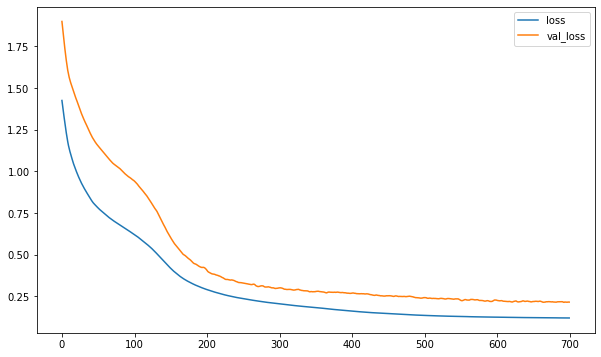

In [22]:
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(10, 6))

In [23]:
# 検証データを使用して予測精度を計算する
pred_val_y = model.predict(val_x_scaled)
r2_score(val_y_scaled, pred_val_y)

0.838

## ニューラルネットワークモデルを改良する


In [24]:
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(128, input_shape=(train_x.shape[1],))) # ニューロン数を3から128に変更
model.add(Activation('relu'))
model.add(Dense(128)) # ニューロン数を3から128に変更
model.add(Activation('relu'))
model.add(Dense(1))
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1280      
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_x_scaled, train_y_scaled, batch_size=128, epochs=700, validation_data = (val_x_scaled, val_y_scaled), verbose=1)

Epoch 1/700
3/3 [==============================] - 1s 96ms/step - loss: 0.8441 - val_loss: 0.7599
Epoch 2/700
3/3 [==============================] - 0s 17ms/step - loss: 0.3671 - val_loss: 0.4128
Epoch 3/700
3/3 [==============================] - 0s 16ms/step - loss: 0.2364 - val_loss: 0.3181
Epoch 4/700
3/3 [==============================] - 0s 19ms/step - loss: 0.2410 - val_loss: 0.2699
Epoch 5/700
3/3 [==============================] - 0s 15ms/step - loss: 0.2139 - val_loss: 0.2264
Epoch 6/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1625 - val_loss: 0.2273
Epoch 7/700
3/3 [==============================] - 0s 17ms/step - loss: 0.1406 - val_loss: 0.2489
Epoch 8/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1414 - val_loss: 0.2407
Epoch 9/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1358 - val_loss: 0.2104
Epoch 10/700
3/3 [==============================] - 0s 15ms/step - loss: 0.1256 - val_loss: 0.1810
Epoch 11/700
3/3 [=

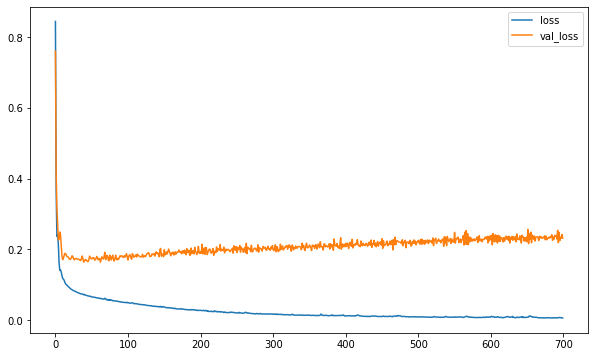

In [26]:
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(10, 6))

In [27]:
# 検証データを使用して予測精度を計算する
pred_val_y = model.predict(val_x_scaled)
r2_score(val_y_scaled, pred_val_y)

0.826

### 学習不足と過学習
ニューロンを増やした学習では、最初は順調に誤差が小さくなっていますが、検証データに対しては100エポックを少し過ぎたあたりから、改善するどころかどんどん誤差が大きくなっています。

しかし、この付近ではニューロンが少ないモデルよりも検証データへの誤差が小さくなっています。

最初のニューロンの少ないモデルは、データに対して十分に適合できておらず、まだ改善の余地を残している適合不足の状態です。対して、ニューロンを増やしたモデルでは、訓練データに適合しすぎて過剰適合の状態です。

ニューラルネットワークの改良では、適合不足でもなく過剰適合でもない丁度よい状態を見つけることが必要になります。

また、ニューラルネットワークは他のモデルに比べて学習に非常に多くの時間がかかります。そこで、学習を効率的に進めることも合わせて考慮する必要があります。




## 早期終了（Early Stopping）を導入する
過学習が発生する一つの原因として、程よく訓練データに適合した状態を通り過ぎ、訓練データに過剰適合するまで学習を継続してしまったことがあります。

そこで、検証データに対する誤差が大きくなる前に、早期終了(Early Stopping)を行う設定を追加します。

早期終了は、学習時にfitメソッドの引数として、各エポック実行後に呼び出される、コールバック関数を設定することで実装できます。

In [28]:
# モデルには先ほど学習したパラメータがすでに設定されているので、
# 学習状態をリセットするために再度モデルを定義します。モデルの内容は先ほどと変わりありません。
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(128, input_shape=(train_x.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1280      
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 activation_5 (Activation)   (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [29]:
# EarlyStoppingの設定。patienceに指定した回数だけ連続で検証データの誤差が増えた場合に早期終了
es = EarlyStopping(monitor='val_loss',
                       patience=10,
                       verbose=1)

In [30]:
# fitの引数にesを設定
history = model.fit(train_x_scaled, train_y_scaled, batch_size=128, epochs=700, validation_data = (val_x_scaled, val_y_scaled), verbose=1, callbacks=[es])

Epoch 1/700
3/3 [==============================] - 1s 91ms/step - loss: 0.8441 - val_loss: 0.7599
Epoch 2/700
3/3 [==============================] - 0s 19ms/step - loss: 0.3671 - val_loss: 0.4128
Epoch 3/700
3/3 [==============================] - 0s 16ms/step - loss: 0.2364 - val_loss: 0.3181
Epoch 4/700
3/3 [==============================] - 0s 16ms/step - loss: 0.2410 - val_loss: 0.2699
Epoch 5/700
3/3 [==============================] - 0s 18ms/step - loss: 0.2139 - val_loss: 0.2264
Epoch 6/700
3/3 [==============================] - 0s 15ms/step - loss: 0.1625 - val_loss: 0.2273
Epoch 7/700
3/3 [==============================] - 0s 18ms/step - loss: 0.1406 - val_loss: 0.2489
Epoch 8/700
3/3 [==============================] - 0s 20ms/step - loss: 0.1414 - val_loss: 0.2407
Epoch 9/700
3/3 [==============================] - 0s 15ms/step - loss: 0.1358 - val_loss: 0.2104
Epoch 10/700
3/3 [==============================] - 0s 15ms/step - loss: 0.1256 - val_loss: 0.1810
Epoch 11/700
3/3 [=

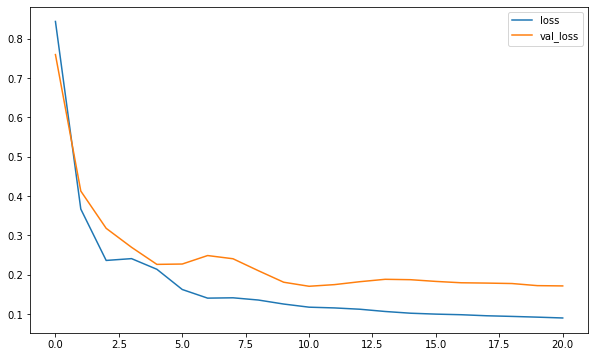

In [31]:
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(10, 6))

In [32]:
# 検証データを使用して予測精度を計算する
pred_val_y = model.predict(val_x_scaled)
r2_score(val_y_scaled, pred_val_y)

0.871

早期終了を入れると、学習にかかる時間も短くて済み、精度も向上しました。<br>

## 追加の最適化を導入する
ニューラルネットワークのさらなる最適化を行い精度向上を図ります。
今回は過学習を緩和する代表的な手法であるドロップアウトを適用してみます。

In [33]:
tf.random.set_seed(0)
model = Sequential()
# 中間層1
model.add(Dense(128, input_shape=(train_x.shape[1],)))
model.add(Activation('relu')) 
model.add(Dropout(0.2)) # ドロップアウトの追加
# 中間層2
model.add(Dense(128))
model.add(Activation('relu')) 
model.add(Dropout(0.2)) # ドロップアウトの追加
# 出力層
model.add(Dense(1))
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1280      
                                                                 
 activation_6 (Activation)   (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 activation_7 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [34]:
history = model.fit(train_x_scaled, train_y_scaled, batch_size=128, epochs=700, validation_data = (val_x_scaled, val_y_scaled), verbose=1, callbacks=[es]) # EarlyStoppingを設定

Epoch 1/700
3/3 [==============================] - 1s 86ms/step - loss: 0.9010 - val_loss: 0.7715
Epoch 2/700
3/3 [==============================] - 0s 14ms/step - loss: 0.4275 - val_loss: 0.4247
Epoch 3/700
3/3 [==============================] - 0s 14ms/step - loss: 0.3054 - val_loss: 0.3312
Epoch 4/700
3/3 [==============================] - 0s 17ms/step - loss: 0.2818 - val_loss: 0.2897
Epoch 5/700
3/3 [==============================] - 0s 15ms/step - loss: 0.2869 - val_loss: 0.2442
Epoch 6/700
3/3 [==============================] - 0s 15ms/step - loss: 0.2185 - val_loss: 0.2343
Epoch 7/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1972 - val_loss: 0.2548
Epoch 8/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1968 - val_loss: 0.2706
Epoch 9/700
3/3 [==============================] - 0s 16ms/step - loss: 0.1999 - val_loss: 0.2507
Epoch 10/700
3/3 [==============================] - 0s 15ms/step - loss: 0.1736 - val_loss: 0.2117
Epoch 11/700
3/3 [=

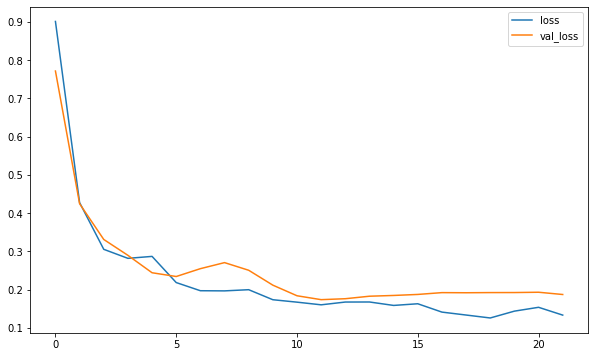

In [35]:
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(10, 6))

In [36]:
# 検証データを使用して予測精度を計算する
pred_val_y = model.predict(val_x_scaled)
r2_score(val_y_scaled, pred_val_y)

0.859

ドロップアウトは代表的な最適化手法ですが、扱うデータにより必ず精度が向上するわけではありません。各層のノード数や層数、学習率、ミニバッチのサイズ、などを調整することで、さらに精度が向上する可能性があります。

このノートブックは以上です。